# libraries

In [38]:
import cometspy as c
import os
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import time

# data - models and diet

## diet

In [39]:
#diet
diet = pd.read_excel('/Volumes/Mac Local/IITM/PhD/Coursework Sem 2/CSB/Project/diet_fiber.xlsx')
#diet = pd.read_csv('/Volumes/Mac Local/IITM/PhD/Coursework Sem 2/CSB/metabolic_modelling/basic_codes/data/Magnusdottir_2017_TableS12_diets.csv')
diet.head()

,metabolite_ID,fiber
0,etoh,1.804608
1,h2o,14384.112175
2,caro,0.001040
3,retinol,0.087067
4,thm,0.572890


In [40]:
diet_dict = dict(zip(diet['metabolite_ID'], diet['fiber'])) #initial diet dictionary


In [41]:
diet_dict

{'etoh': 1.80460775551116,
 'h2o': 14384.1121754819,
 'caro': 0.00103971551974676,
 'retinol': 0.0870674751937054,
 'thm': 0.572890021033352,
 'adpcbl': 2.03256941776663e-07,
 'ribflv': 0.1,
 'nac': 0.0379990961208178,
 'ncam': 0.0171320167824808,
 'pnto_R': 0.00434292488066779,
 'pydam': 0.1,
 'pydxn': 0.1,
 'pydx': 0.1,
 'btn': 3.79428236880688e-05,
 '10fthf': 2.01660121409281e-05,
 '5mthf': 0.1,
 'thf': 2.14398846582131e-05,
 'ascb_L': 0.119861595024984,
 'vitd3': 0.1,
 'avite1': 0.1,
 'phyQ': 0.1,
 'ca2': 2.61441890609432,
 'cl': 18.3250207209531,
 'k': 9.21993459573523,
 'mg2': 2.46677100837975,
 'na1': 11.7111544116189,
 'pi': 1.76849297025158,
 'cu2': 0.1,
 'fe2': 0.0336069741728728,
 'fe3': 0.0336069741728728,
 'mn2': 0.0138066704157699,
 'zn2': 0.1,
 'mnl': 0.213079643159738,
 'xylt': 0.0218567694734893,
 'lcts': 2.10409185577339,
 'malt': 0.0636102181229191,
 'sucr': 10.8565294094517,
 'fru': 12.4566344132478,
 'gal': 0.0799870256825249,
 'cellul': 0.0188193391109082,
 'ala_L

## models

In [42]:
# model dict to store the models

models_dir = "/Volumes/Mac Local/IITM/PhD/Coursework Sem 2/CSB/Project/Models/models/models1/m"
model_files = sorted(os.listdir(models_dir))

models_meta = {} # id: name
models = {} # id: model
#comets_models = {} # id: comets model

for i in range(3): #change range according to the number of models
    model_name = model_files[i].split(".")[0]
    model_path = os.path.join(models_dir, model_files[i])
    models_meta[i] = model_name #update metadata
    print('loading', i,'th model of 20 models...')

    model = cobra.io.read_sbml_model(model_path) 
    models[i] = model #update models dict
    #comets_model = c.model(model)

print('Done loading the models!')
for i in range (3):
    o2_rxn = models[i].reactions.get_by_id("EX_o2(e)")
    o2_rxn.lower_bound = 0
    print(f"O2 exchange bounds: {o2_rxn.lower_bound} to {o2_rxn.upper_bound}")
    

loading 0 th model of 20 models...
loading 1 th model of 20 models...
loading 2 th model of 20 models...
Done loading the models!
O2 exchange bounds: 0 to 1000.0
O2 exchange bounds: 0 to 1000.0
O2 exchange bounds: 0 to 1000.0


# preprocessing steps for models

# monocultures

In [76]:
#parameters - chemostat condition
#part1
dilution_rate = 0.017
mono_params = c.params()

mono_params.set_param("spaceWidth", 0.1)
mono_params.set_param("defaultVmax", 20.) #vmax = 20 mmol gDW-1h-1 for all metabolites
mono_params.set_param("defaultKm", 5e-5) #km = 0.05 mmol

mono_params.set_param('timeStep', 0.1) #hours - The amount of time between two consecutive simulation updates
mono_params.set_param('maxSpaceBiomass', 10.) #gDW
#mono_params.set_param('maxCycles', 500) #duration of simulation in timesteps - number of simulation cycles #30 hours
mono_params.set_param('deathRate', dilution_rate)
mono_params.set_param('metaboliteDilutionRate', dilution_rate)
#save media and flux data
mono_params.set_param('writeFluxLog', True)
mono_params.set_param('writeMediaLog', True)
mono_params.set_param('FluxLogRate', 1)
mono_params.set_param('MediaLogRate', 1)
mono_params.set_param('writeBiomassLog', True) 
mono_params.set_param('writeTotalBiomassLog', True) #save to output if True
mono_params.show_params()


,VALUE,UNITS
BiomassLogName,biomass,
BiomassLogRate,1,cycles
FluxLogName,flux_out,
FluxLogRate,1,cycles
MediaLogName,media_out,
...,...,...
writeBiomassLog,True,logical
writeFluxLog,True,logical
writeMediaLog,True,logical
writeSpecificMediaLog,False,logical


In [45]:
os.environ['COMETS_HOME'] = '/Users/sandhyavasudevan/comets_macos/comets_2.12.3'
os.environ['GUROBI_HOME'] = '/Library/gurobi1003/macos_universal2'  # Replace with your actual path
os.environ['GUROBI_COMETS_HOME'] = os.environ['GUROBI_HOME']

In [46]:
models_meta

{0: 'Bifidobacterium_adolescentis_ATCC_15703',
 1: 'Faecalibacterium_prausnitzii_ERR1022279',
 2: 'Lactobacillus_brevis_DSM_20054'}

In [73]:
# Loop over different initial biomasses
# Initialize biomass_results and flux_results as nested dictionaries
initial_biomasses = [0.01, 0.02, 0.1]
model_indices = [0, 1, 2]

biomass_results = {init_pop: {i: None for i in model_indices} for init_pop in initial_biomasses}
flux_results = {init_pop: {i: None for i in model_indices} for init_pop in initial_biomasses}

for init_pop in [0.01, 0.02, 0.1]:
    for i in [0, 1, 2]:  # Models 0, 1, 2
        model = models[i]
        comets_model = c.model(model)
        comets_model.id = f'model{i}'
        comets_model.initial_pop = [0, 0, init_pop]  # Set the initial population
        
        comets_model.open_exchanges()

        # Create layout
        print(f'Running simulation for model {i} with initial biomass {init_pop}...')
        mono_layout = c.layout(comets_model)
        
        # Set diet and media conditions (as you already have)
        for met in diet_dict:
            metabolite = f'{met}[e]'
            conc = diet_dict[met]
            if metabolite in mono_layout.media['metabolite'].values:
                mono_layout.set_specific_metabolite(metabolite, conc)

        # Set media refresh rate
        for met in mono_layout.media['metabolite']:
            initconc = mono_layout.media[mono_layout.media['metabolite'] == met]['init_amount'].values[0]
            refreshrate = initconc * dilution_rate
            mono_layout.set_specific_refresh(met, refreshrate)

        # Run the simulation
        simulation = c.comets(mono_layout, mono_params)
        simulation.run()

        # Debugging: Print the total biomass at different cycles
        print(f"Final Biomass for Model {i}, Init Pop {init_pop}: {simulation.total_biomass}")
        
        # Store the biomass data for this model and initial biomass
        biomass_results[init_pop][i] = simulation.total_biomass  # Assuming this is the correct attribute for biomass

        # Store the flux data for this model and initial biomass
        flux_results[init_pop][i] = simulation.fluxes_by_species

        print(f'Model {i} with initial biomass {init_pop} done!')


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Running simulation for model 0 with initial biomass 0.01...

Running COMETS simulation ...

Debug Here ...
Done!
Final Biomass for Model 0, Init Pop 0.01:      cycle    model0
0        0  0.010000
1        1  0.009983
2        2  0.009966
3        3  0.009949
4        4  0.009932
..     ...       ...
496    496  0.004300
497    497  0.004293
498    498  0.004286
499    499  0.004278
500    500  0.004271

[501 rows x 2 columns]
Model 0 with initial biomass 0.01 done!


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Running simulation for model 1 with initial biomass 0.01...

Running COMETS simulation ...

Debug Here ...
Done!
Final Biomass for Model 1, Init Pop 0.01:      cycle    model1
0        0  0.010000
1        1  0.009983
2        2  0.009966
3        3  0.009949
4        4  0.009932
..     ...       ...
496    496  0.004300
497    497  0.004293
498    498  0.004286
499    499  0.004278
500    500  0.004271

[501 rows x 2 columns]
Model 1 with initial biomass 0.01 done!


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Running simulation for model 2 with initial biomass 0.01...

Running COMETS simulation ...

Debug Here ...
Done!
Final Biomass for Model 2, Init Pop 0.01:      cycle    model2
0        0  0.010000
1        1  0.009983
2        2  0.009966
3        3  0.009949
4        4  0.009932
..     ...       ...
496    496  0.004300
497    497  0.004293
498    498  0.004286
499    499  0.004278
500    500  0.004271

[501 rows x 2 columns]
Model 2 with initial biomass 0.01 done!


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Running simulation for model 0 with initial biomass 0.02...

Running COMETS simulation ...

Debug Here ...
Done!
Final Biomass for Model 0, Init Pop 0.02:      cycle    model0
0        0  0.020000
1        1  0.019966
2        2  0.019932
3        3  0.019898
4        4  0.019864
..     ...       ...
496    496  0.008600
497    497  0.008586
498    498  0.008571
499    499  0.008557
500    500  0.008542

[501 rows x 2 columns]
Model 0 with initial biomass 0.02 done!


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Running simulation for model 1 with initial biomass 0.02...

Running COMETS simulation ...

Debug Here ...
Done!
Final Biomass for Model 1, Init Pop 0.02:      cycle    model1
0        0  0.020000
1        1  0.019966
2        2  0.019932
3        3  0.019898
4        4  0.019864
..     ...       ...
496    496  0.008600
497    497  0.008586
498    498  0.008571
499    499  0.008557
500    500  0.008542

[501 rows x 2 columns]
Model 1 with initial biomass 0.02 done!


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Running simulation for model 2 with initial biomass 0.02...

Running COMETS simulation ...

Debug Here ...
Done!
Final Biomass for Model 2, Init Pop 0.02:      cycle    model2
0        0  0.020000
1        1  0.019966
2        2  0.019932
3        3  0.019898
4        4  0.019864
..     ...       ...
496    496  0.008600
497    497  0.008586
498    498  0.008571
499    499  0.008557
500    500  0.008542

[501 rows x 2 columns]
Model 2 with initial biomass 0.02 done!


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Running simulation for model 0 with initial biomass 0.1...

Running COMETS simulation ...

Debug Here ...
Done!
Final Biomass for Model 0, Init Pop 0.1:      cycle    model0
0        0  0.100000
1        1  0.099830
2        2  0.099660
3        3  0.099491
4        4  0.099322
..     ...       ...
496    496  0.043002
497    497  0.042929
498    498  0.042856
499    499  0.042783
500    500  0.042711

[501 rows x 2 columns]
Model 0 with initial biomass 0.1 done!


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Running simulation for model 1 with initial biomass 0.1...

Running COMETS simulation ...

Debug Here ...
Done!
Final Biomass for Model 1, Init Pop 0.1:      cycle    model1
0        0  0.100000
1        1  0.099830
2        2  0.099660
3        3  0.099491
4        4  0.099322
..     ...       ...
496    496  0.043002
497    497  0.042929
498    498  0.042856
499    499  0.042783
500    500  0.042711

[501 rows x 2 columns]
Model 1 with initial biomass 0.1 done!


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Running simulation for model 2 with initial biomass 0.1...

Running COMETS simulation ...

Debug Here ...
Done!
Final Biomass for Model 2, Init Pop 0.1:      cycle    model2
0        0  0.100000
1        1  0.105094
2        2  0.104925
3        3  0.104755
4        4  0.104586
..     ...       ...
496    496  0.048267
497    497  0.048193
498    498  0.048120
499    499  0.048048
500    500  0.047975

[501 rows x 2 columns]
Model 2 with initial biomass 0.1 done!


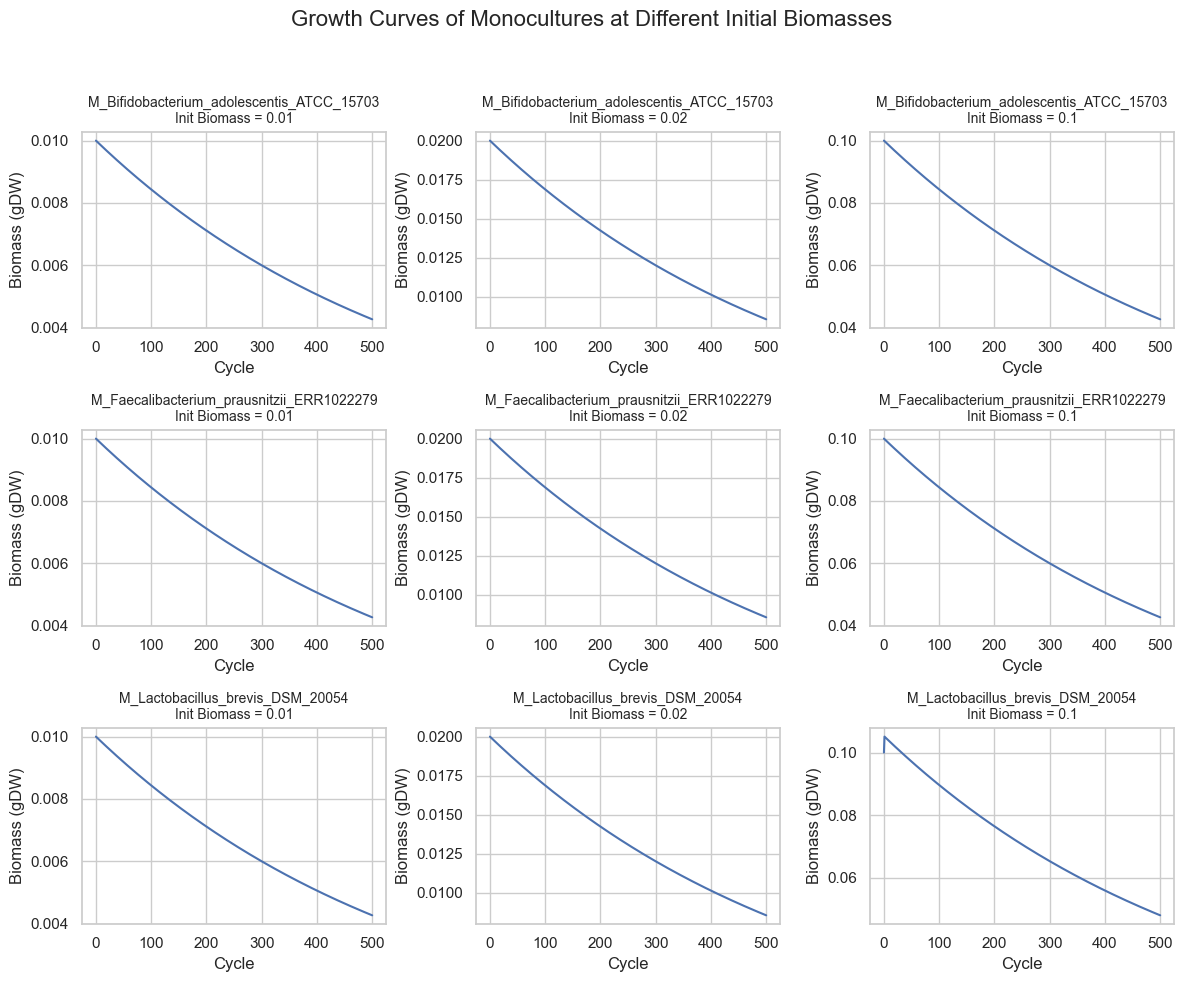

In [80]:
# Set the desired initial biomass order
initial_biomasses = [0.01, 0.02, 0.1]  # ✅ Desired order

# --- Plotting ---
fig, axs = plt.subplots(3, 3, figsize=(12, 10))  # removed sharex=True
fig.suptitle("Growth Curves of Monocultures at Different Initial Biomasses", fontsize=16)

# Loop over each combination
for col, init_pop in enumerate(initial_biomasses):
    biomass_dict = biomass_results[init_pop]  # Use biomass_results here
    
    for row, i in enumerate([0, 1, 2]):
        # Assuming biomass_dict[i] contains the dataframe or data related to biomass over cycles
        df = biomass_dict[i]
        # Use the correct column name (e.g., model0, model1, etc.) in the dataframe
        axs[row, col].plot(df['cycle'], df[f'model{i}'], label=f'Initial Biomass = {init_pop}')
        axs[row, col].set_title(f"{models[i]}\nInit Biomass = {init_pop}", fontsize=10)
        axs[row, col].set_xlabel("Cycle")
        axs[row, col].set_ylabel("Biomass (gDW)")
        axs[row, col].grid(True)
        axs[row, col].tick_params(axis='x', which='both', labelbottom=True)  # ensure x-ticks are shown

# Adjust layout to fit the title and labels
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


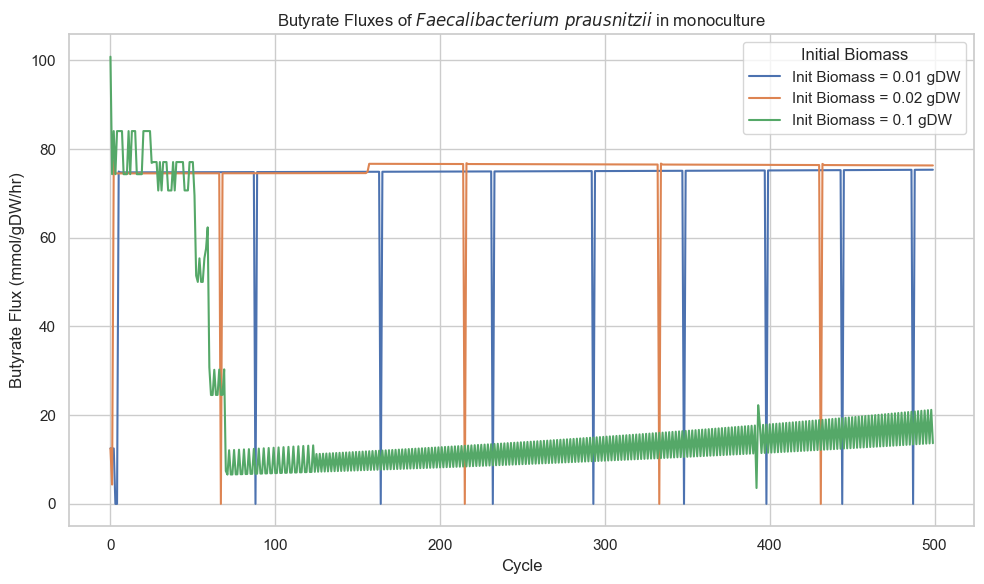

In [81]:
import matplotlib.pyplot as plt

# Plotting Butyrate Fluxes for Faecalibacterium prausnitzii (model1)
plt.figure(figsize=(10, 6))

# Loop over initial biomasses
for init_pop in [0.01, 0.02, 0.1]:
    # Extract the flux data for Faecalibacterium prausnitzii (model1)
    flux_dict = flux_results[init_pop]
    butyrate_flux = flux_dict[1]['model1']['EX_but(e)']  # model 1 corresponds to Faecalibacterium prausnitzii

    # Check if butyrate flux data is available
    if butyrate_flux is not None:
        plt.plot(butyrate_flux.index, butyrate_flux.values, label=f'Init Biomass = {init_pop} gDW')

# Set title with Faecalibacterium prausnitzii in italics using LaTeX
plt.title(r"Butyrate Fluxes of $\it{Faecalibacterium\ prausnitzii}$ in monoculture")
plt.xlabel("Cycle")
plt.ylabel("Butyrate Flux (mmol/gDW/hr)")  # Adjust units if needed
plt.grid(True)
plt.legend(title="Initial Biomass")
plt.tight_layout()
plt.show()


In [52]:
# Community simulation parameters
comm_params = c.params()

#comm_params.set_param('randomSeed', 33)
comm_params.set_param("spaceWidth", 50)
comm_params.set_param("defaultVmax", 20.0) 
comm_params.set_param("defaultKm", 5e-5)

comm_params.set_param('timeStep', 0.1) 
comm_params.set_param('maxSpaceBiomass', 10.0) 
comm_params.set_param('maxCycles', 1000) 
#comm_params.set_param('growthDiffRate', 1)

comm_params.set_param('writeFluxLog', True)
comm_params.set_param('writeMediaLog', True)
comm_params.set_param('FluxLogRate', 1)
comm_params.set_param('MediaLogRate', 1)
comm_params.set_param('writeTotalBiomassLog', True)


#comm_params.set_param("minSpaceBiomass", 1e-3) #gDW


# Set chemostat dilution rate
dilution_rate = 0.017
comm_params.set_param('deathRate', dilution_rate)
comm_params.set_param('metaboliteDilutionRate', dilution_rate)

# Track simulation time
start_time = time.time()


# Set chemostat dilution rate
dilution_rate = 0.017
comm_params.set_param('deathRate', dilution_rate)
comm_params.set_param('metaboliteDilutionRate', dilution_rate)

# Track simulation time
start_time = time.time()


In [61]:


"""
# Initialize an empty layout for the community
community_models = []
initial_pop = 0.1
for i in [0]:  # Assuming 4 species
    model = models[i]
    
    # Convert COBRA model to COMETS model
    comets_model = c.model(model)
    comets_model.id = f'model{i}'
    comets_model.initial_pop = [0, 0, initial_pop]  # Place all species in the same location
    
    comets_model.open_exchanges()

    community_models.append(comets_model)
"""



# Construct a community layout with all species
comm_layout = c.layout()

comets_model1 = c.model(models[1])
comets_model1.id = 'model1'
comets_model1.initial_pop = [0, 0, 0.02] 
comets_model1.open_exchanges()

comets_model0 = c.model(models[0])
comets_model0.id = 'model0'
comets_model0.initial_pop = [0, 0, 0.02] 
comets_model0.open_exchanges()



comm_layout.add_model(comets_model1)
comm_layout.add_model(comets_model0)



# Define initial nutrient conditions
for met in diet_dict:
    metabolite = met + '[e]'
    conc = diet_dict[met]
    
    if metabolite in comm_layout.media['metabolite'].values:
        comm_layout.set_specific_metabolite(metabolite, conc)
    

# Set media refresh rate (chemostat conditions)
for met in comm_layout.media['metabolite']:
    initconc = comm_layout.media[comm_layout.media['metabolite'] == met]['init_amount'].values[0]
    refreshrate = initconc * dilution_rate*10
    comm_layout.set_specific_refresh(met, refreshrate)



print("Community layout constructed!")


building empty layout model
models will need to be added with layout.add_model()


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.
/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Community layout constructed!


In [54]:
print("writeFluxLog:", comm_params.get_param("writeFluxLog"))
print("FluxLogRate:", comm_params.get_param("FluxLogRate"))
print("FluxLogName:", comm_params.get_param("FluxLogName"))
print("maxCycles:", comm_params.get_param("maxCycles"))


writeFluxLog: True
FluxLogRate: 1
FluxLogName: flux_out
maxCycles: 1000


In [ ]:
community_simulation = c.comets(comm_layout, comm_params)
community_simulation.run()

In [62]:
community_simulation_1000 = c.comets(comm_layout, comm_params)
community_simulation_1000.run()


Running COMETS simulation ...

Debug Here ...
Done!


In [63]:
community_simulation_1000.get_metabolite_time_series()['but[e]']
biomass_community = community_simulation_1000.total_biomass
media_community = community_simulation_1000.get_metabolite_time_series()
fluxes_community = community_simulation_1000.fluxes_by_species.copy()

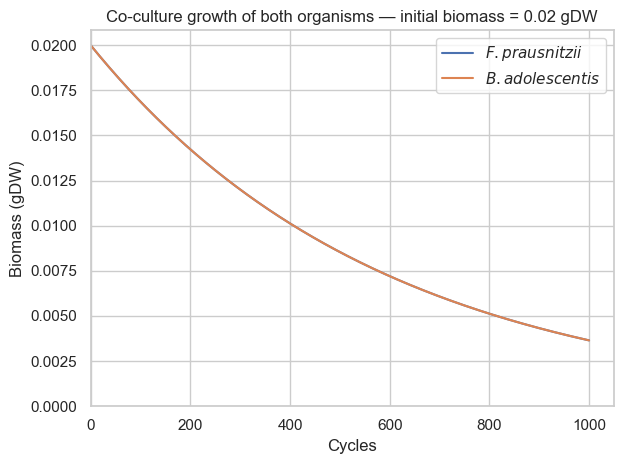

In [68]:
import matplotlib.pyplot as plt

# Custom labels in italics
labels = ['F. prausnitzii', 'B. adolescentis']

# Plotting with manual labels and italics
for i, label in enumerate(labels):
    plt.plot(
        biomass_community['cycle'], 
        biomass_community.iloc[:, i + 1],  # skip the 'cycle' column
        label=f'${label}$'  # Using LaTeX formatting for italics
    )

# Set labels for the axes
plt.xlabel('Cycles')
plt.ylabel('Biomass (gDW)')

# Add title
plt.title('Co-culture growth of both organisms — initial biomass = 0.02 gDW')

# Set the x and y axis limits to start from 0
plt.xlim(left=0)  # Start x-axis at 0
plt.ylim(bottom=0)  # Start y-axis at 0

# Show the legend
plt.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [135]:
biomass_community.columns

Index(['cycle', 'model1', 'model0'], dtype='object')

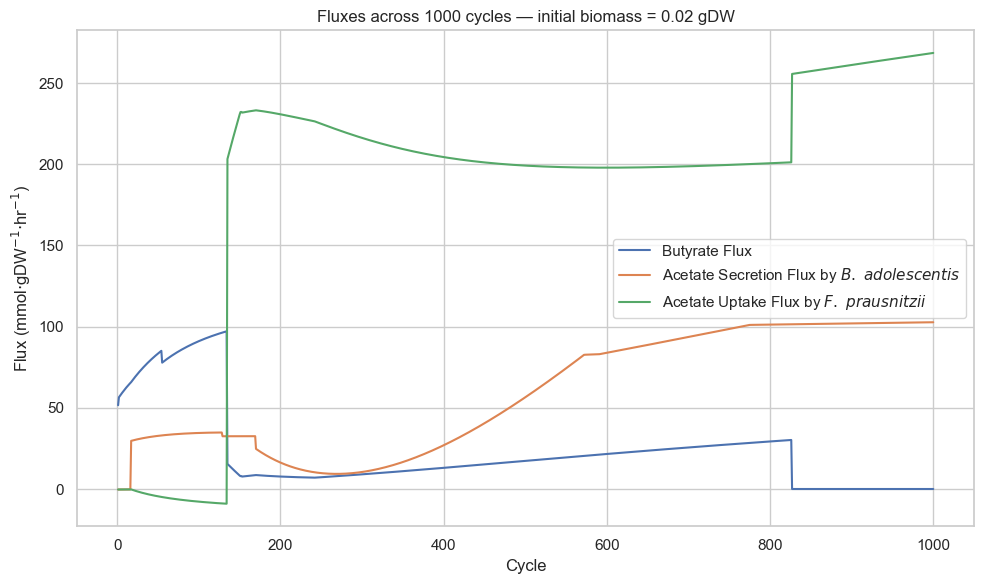

In [69]:
import matplotlib.pyplot as plt

# Extract the Series
but_flux = fluxes_community['model1']['EX_but(e)']
acetate_flux = fluxes_community['model0']['EX_ac(e)']
acetate_flux1 = fluxes_community['model1']['EX_ac(e)']

# Create x-axis
cycles = range(1, len(but_flux) + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(cycles, but_flux.values)
plt.plot(cycles, acetate_flux.values)
plt.plot(cycles, acetate_flux1.values)

# Labels with italics using math text
plt.legend([
    'Butyrate Flux', 
    r'Acetate Secretion Flux by $\mathit{B.\ adolescentis}$', 
    r'Acetate Uptake Flux by $\mathit{F.\ prausnitzii}$'
])
plt.xlabel("Cycle")
plt.ylabel(r"Flux (mmol$\cdot$gDW$^{-1}$$\cdot$hr$^{-1}$)")
plt.title("Fluxes across 1000 cycles — initial biomass = 0.02 gDW")
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
import pandas as pd


cutoff = 0.01
simflux = community_simulation_1000.fluxes_by_species
mid1 = "model0"
mid2 = "model1"

flux1 = simflux[mid1]
print(flux1.columns[:5])

flux2 = simflux[mid2]
# Filter only first 50 cycles based on step column
flux1_filtered = flux1[flux1["cycle"] <= 1000].copy()
flux2_filtered = flux2[flux2["cycle"] <= 1000].copy()

common_mets = set(flux1_filtered.columns[4:]).intersection(flux2_filtered.columns[4:])

mod1_to_mod2 = []
mod2_to_mod1 = []

for metabolite in common_mets:
    flux_mod1 = flux1_filtered[metabolite].fillna(0)
    flux_mod2 = flux2_filtered[metabolite].fillna(0)

    # Case 1: model1 secretes, model2 consumes
    if (flux_mod1 > cutoff).any() and (flux_mod2 < -cutoff).any():
        mod1_to_mod2.append({
            "metabolite": metabolite,
            f"{mid1}_flux": flux_mod1.values,
            f"{mid2}_flux": flux_mod2.values
        })

    # Case 2: model2 secretes, model1 consumes
    if (flux_mod2 > cutoff).any() and (flux_mod1 < -cutoff).any():
        mod2_to_mod1.append({
            "metabolite": metabolite,
            f"{mid2}_flux": flux_mod2.values,
            f"{mid1}_flux": flux_mod1.values
        })


# Convert to DataFrames
df_mod1_to_mod2 = pd.DataFrame(mod1_to_mod2)
df_mod2_to_mod1 = pd.DataFrame(mod2_to_mod1)

# Show summary
print("✅ Metabolites cross-fed from model1 to model2:", len(df_mod1_to_mod2))
print("✅ Metabolites cross-fed from model2 to model1:", len(df_mod2_to_mod1))
print(df_mod1_to_mod2)
print(df_mod2_to_mod1)

Index(['cycle', 'x', 'y', '12PPDt', '23DHMPO'], dtype='object')
✅ Metabolites cross-fed from model1 to model2: 31
✅ Metabolites cross-fed from model2 to model1: 33
     metabolite                                        model0_flux   
0      EX_ac(e)  [-0.31496062992, -0.30272939303, -0.2909782858...  \
1        FRUt1r  [13.317878714, 13.256828916, 13.194833196, 13....   
2         G6PI3  [1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -...   
3     EX_nh4(e)  [-0.0, 0.0054385207224, 0.010691591981, 0.0156...   
4   EX_val_L(e)  [-7.8479309655, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
5         NH4tb  [0.0, -0.0054385207224, -0.010691591981, -0.01...   
6           PGI  [-912.91742099, 960.57983307, 960.94715317, 96...   
7         ALACI  [-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...   
8       EX_h(e)  [331.55227463, 26.982126522, 26.912078269, 26....   
9     EX_co2(e)  [125.54679347, 40.63495809, 40.45639846, 40.23...   
10        VALTA  [-992.15206903, 1000.0, 1000.0, 1000.0, 1000.0...

## Addition of L. brevis    <!-- Slightly smaller -->

In [112]:
#Lactobacillus



"""
# Initialize an empty layout for the community
community_models = []
initial_pop = 0.1
for i in [0]:  # Assuming 4 species
    model = models[i]
    
    # Convert COBRA model to COMETS model
    comets_model = c.model(model)
    comets_model.id = f'model{i}'
    comets_model.initial_pop = [0, 0, initial_pop]  # Place all species in the same location
    
    comets_model.open_exchanges()

    community_models.append(comets_model)
"""



# Construct a community layout with all species
comm_layout_lac = c.layout()

comets_model1 = c.model(models[1])
comets_model1.id = 'model1'
comets_model1.initial_pop = [0, 0, 0.02] 
comets_model1.open_exchanges()

comets_model0 = c.model(models[0])
comets_model0.id = 'model0'
comets_model0.initial_pop = [0, 0, 0.1] 
comets_model0.open_exchanges()

comets_model2 = c.model(models[2])
comets_model2.id = 'model2'
comets_model2.initial_pop = [0, 0, 0.1] 
comets_model2.open_exchanges()



comm_layout_lac.add_model(comets_model0)
comm_layout_lac.add_model(comets_model1)
comm_layout_lac.add_model(comets_model2)




# Define initial nutrient conditions
for met in diet_dict:
    metabolite = met + '[e]'
    conc = diet_dict[met]
    
    if metabolite in comm_layout_lac.media['metabolite'].values:
        comm_layout_lac.set_specific_metabolite(metabolite, conc)
    

# Set media refresh rate (chemostat conditions)
for met in comm_layout_lac.media['metabolite']:
    initconc = comm_layout_lac.media[comm_layout_lac.media['metabolite'] == met]['init_amount'].values[0]
    refreshrate = initconc * dilution_rate*10
    comm_layout_lac.set_specific_refresh(met, refreshrate)



print("Community layout constructed!")



building empty layout model
models will need to be added with layout.add_model()


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.
/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.
/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Community layout constructed!


In [117]:
# Community simulation parameters
comm_params = c.params()

#comm_params.set_param('randomSeed', 33)
comm_params.set_param("spaceWidth", 50)
comm_params.set_param("defaultVmax", 20.0) 
comm_params.set_param("defaultKm", 5e-5)

comm_params.set_param('timeStep', 0.1) 
comm_params.set_param('maxSpaceBiomass', 10.0) 
comm_params.set_param('maxCycles', 500) 
#comm_params.set_param('growthDiffRate', 1)

comm_params.set_param('writeFluxLog', True)
comm_params.set_param('writeMediaLog', True)
comm_params.set_param('FluxLogRate', 1)
comm_params.set_param('MediaLogRate', 1)
comm_params.set_param('writeTotalBiomassLog', True)


#comm_params.set_param("minSpaceBiomass", 1e-3) #gDW


# Set chemostat dilution rate
dilution_rate = 0.017
comm_params.set_param('deathRate', dilution_rate)
comm_params.set_param('metaboliteDilutionRate', dilution_rate)

# Track simulation time
start_time = time.time()


# Set chemostat dilution rate
dilution_rate = 0.017
comm_params.set_param('deathRate', dilution_rate)
comm_params.set_param('metaboliteDilutionRate', dilution_rate)

# Track simulation time
start_time = time.time()


In [118]:
community_simulation_lac = c.comets(comm_layout_lac, comm_params)
community_simulation_lac.run()
biomass_community = community_simulation_lac.total_biomass
media_community = community_simulation_lac.get_metabolite_time_series()
fluxes_community = community_simulation_lac.fluxes_by_species.copy()
community_simulation_lac.get_metabolite_time_series()['but[e]']


Running COMETS simulation ...

Debug Here ...
Done!


0      0.005727
1      0.125721
2      0.204786
3      0.221438
4      0.238061
         ...   
496    5.806634
497    5.813762
498    5.820879
499    5.827984
500    5.835076
Name: but[e], Length: 501, dtype: float64

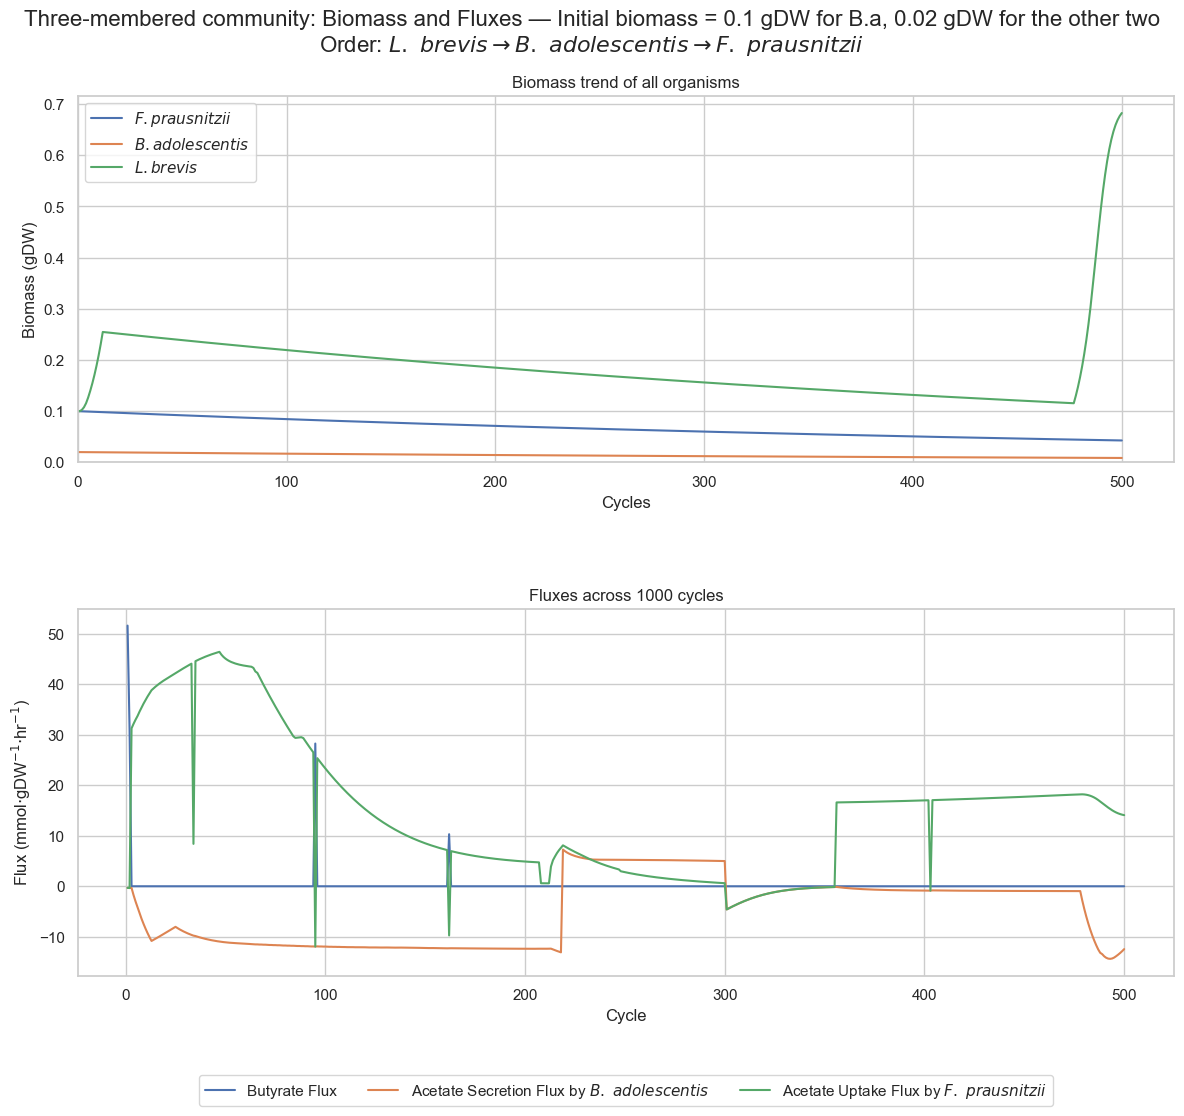

In [119]:
import matplotlib.pyplot as plt

# Create figure with 2 subplots (stacked vertically)
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# ==== Plot 1: Biomass ====
labels = ['F. prausnitzii', 'B. adolescentis', 'L.brevis']

for i, label in enumerate(labels):
    axes[0].plot(
        biomass_community['cycle'], 
        biomass_community.iloc[:, i + 1],
        label=f'${label}$'
    )

axes[0].set_xlabel('Cycles')
axes[0].set_ylabel('Biomass (gDW)')
axes[0].set_title('Biomass trend of all organisms')
axes[0].set_xlim(left=0)
axes[0].set_ylim(bottom=0)
axes[0].legend()
axes[0].grid(True)

# ==== Plot 2: Fluxes ====
but_flux = fluxes_community['model1']['EX_but(e)']
acetate_flux = fluxes_community['model0']['EX_ac(e)']
acetate_flux1 = fluxes_community['model1']['EX_ac(e)']
cycles = range(1, len(but_flux) + 1)

axes[1].plot(cycles, but_flux.values)
axes[1].plot(cycles, acetate_flux.values)
axes[1].plot(cycles, acetate_flux1.values)

axes[1].legend([
    'Butyrate Flux', 
    r'Acetate Secretion Flux by $\mathit{B.\ adolescentis}$', 
    r'Acetate Uptake Flux by $\mathit{F.\ prausnitzii}$'
], loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3)

axes[1].set_xlabel("Cycle")
axes[1].set_ylabel(r"Flux (mmol$\cdot$gDW$^{-1}$$\cdot$hr$^{-1}$)")
axes[1].set_title("Fluxes across 1000 cycles")
axes[1].grid(True)

# Adjust layout to make room for everything
plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Shrink tight_layout area a bit
plt.subplots_adjust(hspace=0.4)  # Add space between the subplots

# Set main title higher to avoid overlap
plt.suptitle(
    r"Three-membered community: Biomass and Fluxes — Initial biomass = 0.1 gDW for B.a, 0.02 gDW for the other two" "\n"
    r"Order: $\mathit{L.\ brevis} \rightarrow \mathit{B.\ adolescentis} \rightarrow \mathit{F.\ prausnitzii}$",
    fontsize=16, y=0.99
)



plt.show()


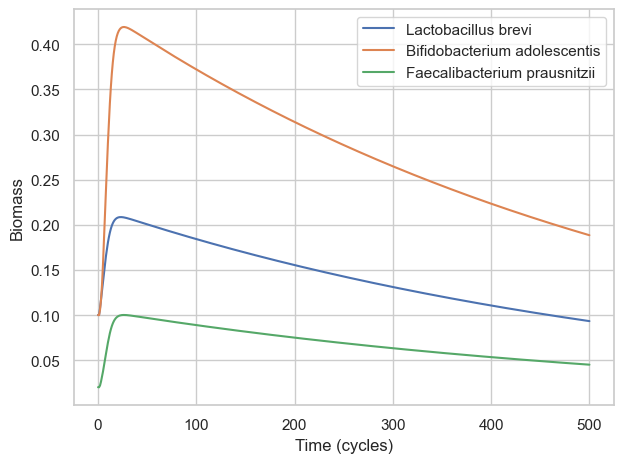

In [ ]:
import matplotlib.pyplot as plt

# Custom labels in the order you want
labels = ['Lactobacillus brevi', 'Bifidobacterium adolescentis', 'Faecalibacterium prausnitzii' ]

# Plotting with manual labels
for i, label in enumerate(labels):
    plt.plot(
        biomass_community['cycle'], 
        biomass_community.iloc[:, i + 1],  # skip the 'cycle' column
        label=label
    )

plt.xlabel('Time (cycles)')
plt.ylabel('Biomass')
plt.legend()
plt.tight_layout()
plt.show()


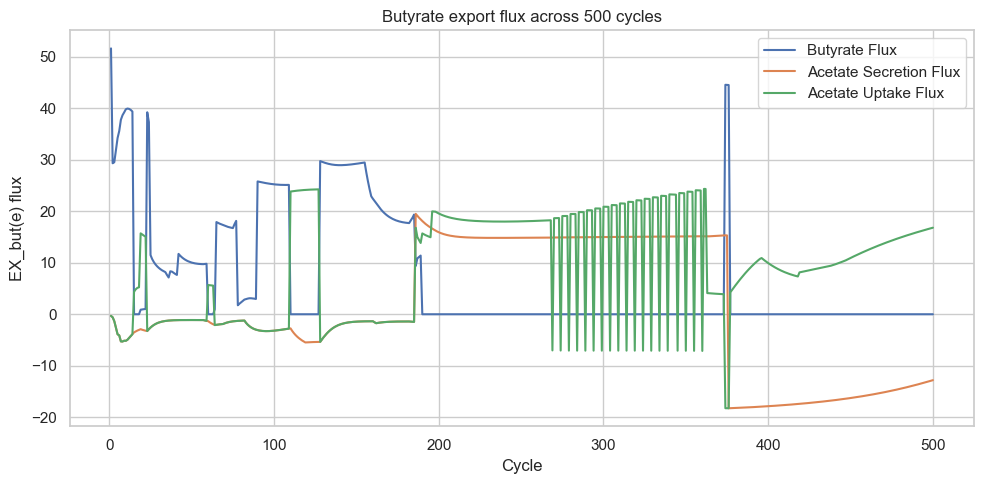

In [ ]:
import matplotlib.pyplot as plt

# Extract the Series
but_flux = fluxes_community['model1']['EX_but(e)']
acetate_flux = fluxes_community['model0']['EX_ac(e)']
acetate_flux1= fluxes_community['model1']['EX_ac(e)']

# Create x-axis as cycle numbers from 1 to 500 (assuming one value every 2 cycles)
cycles = range(1, len(but_flux) + 1)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(cycles, but_flux.values)
plt.plot(cycles, acetate_flux.values)
plt.plot(cycles, acetate_flux1.values)
#plt.ylim(-40, 140)
plt.legend(['Butyrate Flux', 'Acetate Secretion Flux', 'Acetate Uptake Flux'])
plt.xlabel("Cycle")
plt.ylabel("EX_but(e) flux")
plt.title("Butyrate export flux across 500 cycles")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
models_meta

{0: 'Bifidobacterium_adolescentis_ATCC_15703',
 1: 'Faecalibacterium_prausnitzii_ERR1022279',
 2: 'Lactobacillus_brevis_DSM_20054'}

## INVASIONS

In [12]:
def monoculture_sim(params, model, model_id, initial_biomass, dilution_rate, diet_dict, method):
    '''
    params: c.params object
    model: cobra.Model
    model_id: numerical, model id
    initial_biomass: numerical, initial gDW of the species
    diet: dict, diet of the model - metabolite: concentration
    method: 'batch' or 'chemostat'
    '''
    
    #make comets model and set model id
    comets_model = c.model(model)
    comets_model.id = 'model' + str(model_id)

    #set initial population and open exchanges
    comets_model.initial_pop = [0, 0, initial_biomass] # x, y, gDW
    comets_model.open_exchanges() # lower bounds and upper bounds for exchange reactions set to -1000 and 1000 respectively
    
    #create layout
    mono_layout = c.layout(comets_model)

    ## NOTE: cobrapy media are set using exchange reaction IDs, whereas COMETS media are set using metabolite ids
    #set diet
    for met in diet_dict:
        metabolite = (met+'[e]')
        conc = diet_dict[met]
        #print(metabolite, conc)
        if metabolite in mono_layout.media['metabolite'].values:
            mono_layout.set_specific_metabolite(metabolite, conc) 
        
    if method == 'chemostat':

        #dilution_rate = params.get_param('dilutionRate')

        #set media refresh rate - chemostat conditions
        for met in mono_layout.media['metabolite']:
            initconc = mono_layout.media[mono_layout.media['metabolite'] == met]['init_amount'].values[0]
            refreshrate = initconc*dilution_rate
            mono_layout.set_specific_refresh(met, refreshrate)
        
    simulation = c.comets(mono_layout, params)

    return simulation



In [13]:
def invasion(invader_dict, resident_community_dict, resident_sim, initial_biomass, dilution_rate, diet_dict, total_cycles, params, method, models_dict):
    ''' 
    invader_dict: dict, invader model id: cobra model
    resident_community_dict: dict, resident model ids: cobra models
    resident_sim: c.comets object, resident community simulation
    initial_biomass: numerical, initial biomass of the invader
    dilution_rate: numerical, dilution rate of the chemostat
    diet: dict, diet of the model - metabolite: concentration
    total_cycles: numerical, total cycles of the simulation of the previous simulation
    params: c.params object
    method: 'batch' or 'chemostat'
    models_dict: dict, all models
    '''
    
    # Combine resident and invader model ids
    model_id_list = list(resident_community_dict.keys()) + list(invader_dict.keys())
    print("I am here")
    
    # Initialize initial biomass dict
    initial_biomass_dict = {}

    # Get biomass values for all resident models
    for resident in resident_community_dict:
        biomass_col = f'model{resident}'  # Format as 'model{resident}'
        if biomass_col in resident_sim.total_biomass.columns:
            resbiomass = resident_sim.total_biomass[biomass_col].values[-1]
            initial_biomass_dict[resident] = resbiomass
            print(f"[✅] Final biomass for resident model{resident}: {resbiomass}")
        else:
            raise KeyError(f"[❌] Biomass column '{biomass_col}' not found in simulation output.")

    # Handle invader biomass
    for invader in invader_dict:
        biomass_col = f'model{invader}'  # Format as 'model{invader}'
        if biomass_col in resident_sim.total_biomass.columns:
            invbiomass = resident_sim.total_biomass[biomass_col].values[-1]
            initial_biomass_dict[invader] = initial_biomass + invbiomass
            print(f"[🧬] Updated invader biomass (existing): {initial_biomass + invbiomass}")
        else:
            initial_biomass_dict[invader] = initial_biomass
            print(f"[🧬] Initial biomass for new invader: {initial_biomass}")

    print("I am here too")

    # Get updated media at last cycle
    media_df = resident_sim.media
    media_df = media_df[media_df['cycle'] == total_cycles].reset_index(drop=True)
    upd_diet_dict = dict(zip(media_df['metabolite'], media_df['conc_mmol']))

    # Sync metabolite format for COMETS media
    sync_diet = {}
    for met in diet_dict:
        metabolite = met + '[e]'
        sync_diet[metabolite] = diet_dict[met]
    diet_dict = sync_diet

    all_mets = set(diet_dict.keys()).union(set(upd_diet_dict.keys()))
    print(f'All metabolites: {len(all_mets)}')

    # Update diet dictionary with missing metabolites
    for met in all_mets:
        if met not in upd_diet_dict:
            upd_diet_dict[met] = diet_dict.get(met, 0.0)

    # Check method validity
    if method not in ['batch', 'chemostat']:
        raise ValueError("Invalid method. Choose 'batch' or 'chemostat'.")

    # Create COMETS layout
    colayout = c.layout()

    # Add each model to the layout
    print(f'Model list: {model_id_list}')
    for modelid in model_id_list:
        model = models_dict[modelid]
        print(f'Adding model: {modelid}')
        comets_model = c.model(model)
        comets_model.id = f'model{modelid}'  # Use 'model{modelid}' consistently
        comets_model.initial_pop = [0, 0, initial_biomass_dict[modelid]]
        comets_model.open_exchanges()
        print(f'Initial biomass for model {modelid}: {initial_biomass_dict[modelid]}')
        colayout.add_model(comets_model)

    # Set media concentrations based on updated diet
    for met, conc in upd_diet_dict.items():
        if met in colayout.media['metabolite'].values:
            colayout.set_specific_metabolite(met, conc)

    # Set refresh rate for chemostat if method is 'chemostat'
    if method == 'chemostat':
        for met in colayout.media['metabolite']:
            initconc = colayout.media[colayout.media['metabolite'] == met]['init_amount'].values[0]
            refreshrate = initconc * dilution_rate
            colayout.set_specific_refresh(met, refreshrate)

    # Run COMETS simulation
    invsim = c.comets(colayout, params)
    
    print("[✅] Invasion simulation completed successfully!")
    
    return invsim


In [77]:
import itertools
import pandas as pd
import time

# Define parameters for chemostat condition
dilution_rate = 0.017  # /hr
#initial_biomass = 0.02  # Initial population

def invasion_run(invasion_seq):
    simlist = []
    simdf = {}

    # ✅ List of dictionaries to build the butyrate flux log
    butyrate_flux_log = []

    # ----- Monoculture step -----
    inoc = invasion_seq[0]
    print("inoc =", inoc)
    # 🧠 Conditional biomass: 0.1 for model[0], else 0.02
    model = models[inoc]

    mono_biomass = 0.02# if inoc == 0 else 0.02 
    mono_params.set_param('maxCycles', 200)  # Set max cycles for monoculture

    sim1 = monoculture_sim(
        params=mono_params, model=model, model_id=inoc,
        initial_biomass=mono_biomass, dilution_rate=dilution_rate, 
        diet_dict=diet_dict, method='chemostat'
    )
    sim1.run()
    simlist.append(sim1)
    print(f"Monoculture simulation for model {inoc} completed.")

    simdf[inoc] = sim1.total_biomass
    simdf[inoc]['invseq'] = 1

    # ✅ Log butyrate flux from monoculture
    but_flux_series = sim1.fluxes_by_species.get('model1', {}).get('EX_but(e)', pd.Series([0]*200))

    if not isinstance(but_flux_series, pd.Series):
        but_flux_series = pd.Series([but_flux_series] * 200)

    for cycle, flux in enumerate(but_flux_series):
        butyrate_flux_log.append({
            'cycle': cycle,
            'invasion_stage': 1,
            'model': 'model1',
            'butyrate_flux': flux
        })

    # ----- Sequential invasions -----
    for invcount, invader in enumerate(invasion_seq[1:], start=2):
        resident_models = {invasion_seq[j]: models[invasion_seq[j]] for j in range(invcount - 1)}
        invader_model = models[invader]

        invader_dict = {invader: invader_model}
        resident_community_dict = resident_models
        resident_sim = simlist[invcount - 2]
        total_cycles = 200# if invcount == 3 else 50
    
        print(invcount,"HeHeHe")
        params = comm_params
        comm_params.set_param('maxCycles', total_cycles)
        method = 'chemostat'
        # Set initial biomass conditionally: 0.1 for model[0], else 0.02
        
        inv_biomass = 0.02# if invader == 0 else 0.02

        sim = invasion(
            invader_dict, resident_community_dict, resident_sim,
            inv_biomass, dilution_rate, diet_dict,
            total_cycles, params, method, models)

        sim.run()
        print(f"Simulation for invader {invader} completed.")
        simlist.append(sim)

        simdf[invader] = sim.total_biomass
        simdf[invader]['invseq'] = invcount

        # ✅ Log butyrate flux from invasion step
        but_flux_series = sim.fluxes_by_species.get('model1', {}).get('EX_but(e)', pd.Series([0]*200))

        if not isinstance(but_flux_series, pd.Series):
            but_flux_series = pd.Series([but_flux_series] * 200)

        for cycle, flux in enumerate(but_flux_series):
            butyrate_flux_log.append({
                'cycle': cycle + 1 + (invcount - 1) * 200,
                'invasion_stage': invcount,
                'model': 'model1',
                'butyrate_flux': flux
            })

    # Combine biomass data
    biodf = pd.concat(simdf.values())
    biodf.to_csv(f'biomass_sequence_{"-".join(map(str, invasion_seq))}.csv')

    # Combine and save flux data
    flux_df = pd.DataFrame(butyrate_flux_log)
    flux_df.to_csv(f'butyrate_flux_sequence_{"-".join(map(str, invasion_seq))}.csv', index=False)

    return biodf, flux_df


# ----- Run simulations for all invasion sequences -----
import itertools
#all_orders = [(1,2,0)]
#all_orders=[(2,1,0)]
all_orders = list(itertools.permutations([0, 1, 2]))

all_results = {}

for idx, order in enumerate(all_orders):
    print(f"\n▶️ Running invasion sequence {idx+1}/{len(all_orders)}: {order}")
    result_df, flux_data_df = invasion_run(order)
    all_results[f"order_{idx}"] = result_df
    print("✅ One round over!")

# Combine all biomass results
final_df = pd.concat([df.assign(scenario=k) for k, df in all_results.items()])
final_df.to_csv('all_invasion_results.csv')

print("✅ All done!")



▶️ Running invasion sequence 1/6: (0, 1, 2)
inoc = 0


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.



Running COMETS simulation ...

Debug Here ...
Done!
Monoculture simulation for model 0 completed.
2 HeHeHe
I am here
[✅] Final biomass for resident model0: 0.01423128835
[🧬] Initial biomass for new invader: 0.02
I am here too
All metabolites: 163
building empty layout model
models will need to be added with layout.add_model()
Model list: [0, 1]
Adding model: 0


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 0: 0.01423128835
Adding model: 1


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 1: 0.02
[✅] Invasion simulation completed successfully!

Running COMETS simulation ...

Debug Here ...
Done!
Simulation for invader 1 completed.
3 HeHeHe
I am here
[✅] Final biomass for resident model0: 0.010126478405
[✅] Final biomass for resident model1: 1.3205318338
[🧬] Initial biomass for new invader: 0.02
I am here too
All metabolites: 220
building empty layout model
models will need to be added with layout.add_model()
Model list: [0, 1, 2]
Adding model: 0


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 0: 0.010126478405
Adding model: 1


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 1: 1.3205318338
Adding model: 2


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 2: 0.02
[✅] Invasion simulation completed successfully!

Running COMETS simulation ...

Debug Here ...
Done!
Simulation for invader 2 completed.
✅ One round over!

▶️ Running invasion sequence 2/6: (0, 2, 1)
inoc = 0


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.



Running COMETS simulation ...

Debug Here ...
Done!
Monoculture simulation for model 0 completed.
2 HeHeHe
I am here
[✅] Final biomass for resident model0: 0.01423128835
[🧬] Initial biomass for new invader: 0.02
I am here too
All metabolites: 163
building empty layout model
models will need to be added with layout.add_model()
Model list: [0, 2]
Adding model: 0


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 0: 0.01423128835
Adding model: 2


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 2: 0.02
[✅] Invasion simulation completed successfully!

Running COMETS simulation ...

Debug Here ...
Done!
Simulation for invader 2 completed.
3 HeHeHe
I am here
[✅] Final biomass for resident model0: 0.010126478405
[✅] Final biomass for resident model2: 0.016860393916
[🧬] Initial biomass for new invader: 0.02
I am here too
All metabolites: 222
building empty layout model
models will need to be added with layout.add_model()
Model list: [0, 2, 1]
Adding model: 0


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 0: 0.010126478405
Adding model: 2


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 2: 0.016860393916
Adding model: 1


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 1: 0.02
[✅] Invasion simulation completed successfully!

Running COMETS simulation ...

Debug Here ...
Done!
Simulation for invader 1 completed.
✅ One round over!

▶️ Running invasion sequence 3/6: (1, 0, 2)
inoc = 1


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.



Running COMETS simulation ...

Debug Here ...
Done!
Monoculture simulation for model 1 completed.
2 HeHeHe
I am here
[✅] Final biomass for resident model1: 0.01423128835
[🧬] Initial biomass for new invader: 0.02
I am here too
All metabolites: 163
building empty layout model
models will need to be added with layout.add_model()
Model list: [1, 0]
Adding model: 1


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 1: 0.01423128835
Adding model: 0


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 0: 0.02
[✅] Invasion simulation completed successfully!

Running COMETS simulation ...

Debug Here ...
Done!
Simulation for invader 0 completed.
3 HeHeHe
I am here
[✅] Final biomass for resident model1: 0.010126478405
[✅] Final biomass for resident model0: 0.01423128835
[🧬] Initial biomass for new invader: 0.02
I am here too
All metabolites: 214
building empty layout model
models will need to be added with layout.add_model()
Model list: [1, 0, 2]
Adding model: 1


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 1: 0.010126478405
Adding model: 0


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 0: 0.01423128835
Adding model: 2


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 2: 0.02
[✅] Invasion simulation completed successfully!

Running COMETS simulation ...

Debug Here ...
Done!
Simulation for invader 2 completed.
✅ One round over!

▶️ Running invasion sequence 4/6: (1, 2, 0)
inoc = 1


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.



Running COMETS simulation ...

Debug Here ...
Done!
Monoculture simulation for model 1 completed.
2 HeHeHe
I am here
[✅] Final biomass for resident model1: 0.01423128835
[🧬] Initial biomass for new invader: 0.02
I am here too
All metabolites: 163
building empty layout model
models will need to be added with layout.add_model()
Model list: [1, 2]
Adding model: 1


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 1: 0.01423128835
Adding model: 2


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 2: 0.02
[✅] Invasion simulation completed successfully!

Running COMETS simulation ...

Debug Here ...
Done!
Simulation for invader 2 completed.
3 HeHeHe
I am here
[✅] Final biomass for resident model1: 0.010126478405
[✅] Final biomass for resident model2: 0.016636080659
[🧬] Initial biomass for new invader: 0.02
I am here too
All metabolites: 207
building empty layout model
models will need to be added with layout.add_model()
Model list: [1, 2, 0]
Adding model: 1


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 1: 0.010126478405
Adding model: 2


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 2: 0.016636080659
Adding model: 0


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 0: 0.02
[✅] Invasion simulation completed successfully!

Running COMETS simulation ...

Debug Here ...
Done!
Simulation for invader 0 completed.
✅ One round over!

▶️ Running invasion sequence 5/6: (2, 0, 1)
inoc = 2


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.



Running COMETS simulation ...

Debug Here ...
Done!
Monoculture simulation for model 2 completed.
2 HeHeHe
I am here
[✅] Final biomass for resident model2: 0.01423128835
[🧬] Initial biomass for new invader: 0.02
I am here too
All metabolites: 164
building empty layout model
models will need to be added with layout.add_model()
Model list: [2, 0]
Adding model: 2


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 2: 0.01423128835
Adding model: 0


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 0: 0.02
[✅] Invasion simulation completed successfully!

Running COMETS simulation ...

Debug Here ...
Done!
Simulation for invader 0 completed.
3 HeHeHe
I am here
[✅] Final biomass for resident model2: 0.10504351442
[✅] Final biomass for resident model0: 0.71573703154
[🧬] Initial biomass for new invader: 0.02
I am here too
All metabolites: 228
building empty layout model
models will need to be added with layout.add_model()
Model list: [2, 0, 1]
Adding model: 2


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 2: 0.10504351442
Adding model: 0


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 0: 0.71573703154
Adding model: 1


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 1: 0.02
[✅] Invasion simulation completed successfully!

Running COMETS simulation ...

Debug Here ...
Done!
Simulation for invader 1 completed.
✅ One round over!

▶️ Running invasion sequence 6/6: (2, 1, 0)
inoc = 2


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.



Running COMETS simulation ...

Debug Here ...
Done!
Monoculture simulation for model 2 completed.
2 HeHeHe
I am here
[✅] Final biomass for resident model2: 0.01423128835
[🧬] Initial biomass for new invader: 0.02
I am here too
All metabolites: 164
building empty layout model
models will need to be added with layout.add_model()
Model list: [2, 1]
Adding model: 2


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 2: 0.01423128835
Adding model: 1


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 1: 0.02
[✅] Invasion simulation completed successfully!

Running COMETS simulation ...

Debug Here ...
Done!
Simulation for invader 1 completed.
3 HeHeHe
I am here
[✅] Final biomass for resident model2: 0.22431699293
[✅] Final biomass for resident model1: 0.015512660368
[🧬] Initial biomass for new invader: 0.02
I am here too
All metabolites: 212
building empty layout model
models will need to be added with layout.add_model()
Model list: [2, 1, 0]
Adding model: 2


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 2: 0.22431699293
Adding model: 1


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 1: 0.015512660368
Adding model: 0


/opt/homebrew/anaconda3/envs/comets_env/lib/python3.9/site-packages/cometspy/model.py:667: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.


Initial biomass for model 0: 0.02
[✅] Invasion simulation completed successfully!

Running COMETS simulation ...

Debug Here ...
Done!
Simulation for invader 0 completed.
✅ One round over!
✅ All done!


/var/folders/26/stf2735d0wg2czwkm2dlxlvm0000gn/T/ipykernel_17736/4176794916.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='cycle', y='butyrate_flux', ax=axes[idx], ci=None)
/var/folders/26/stf2735d0wg2czwkm2dlxlvm0000gn/T/ipykernel_17736/4176794916.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='cycle', y='butyrate_flux', ax=axes[idx], ci=None)
/var/folders/26/stf2735d0wg2czwkm2dlxlvm0000gn/T/ipykernel_17736/4176794916.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='cycle', y='butyrate_flux', ax=axes[idx], ci=None)
/var/folders/26/stf2735d0wg2czwkm2dlxlvm0000gn/T/ipykernel_17736/4176794916.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='cycle', y='butyrate_flux', ax=axes[idx

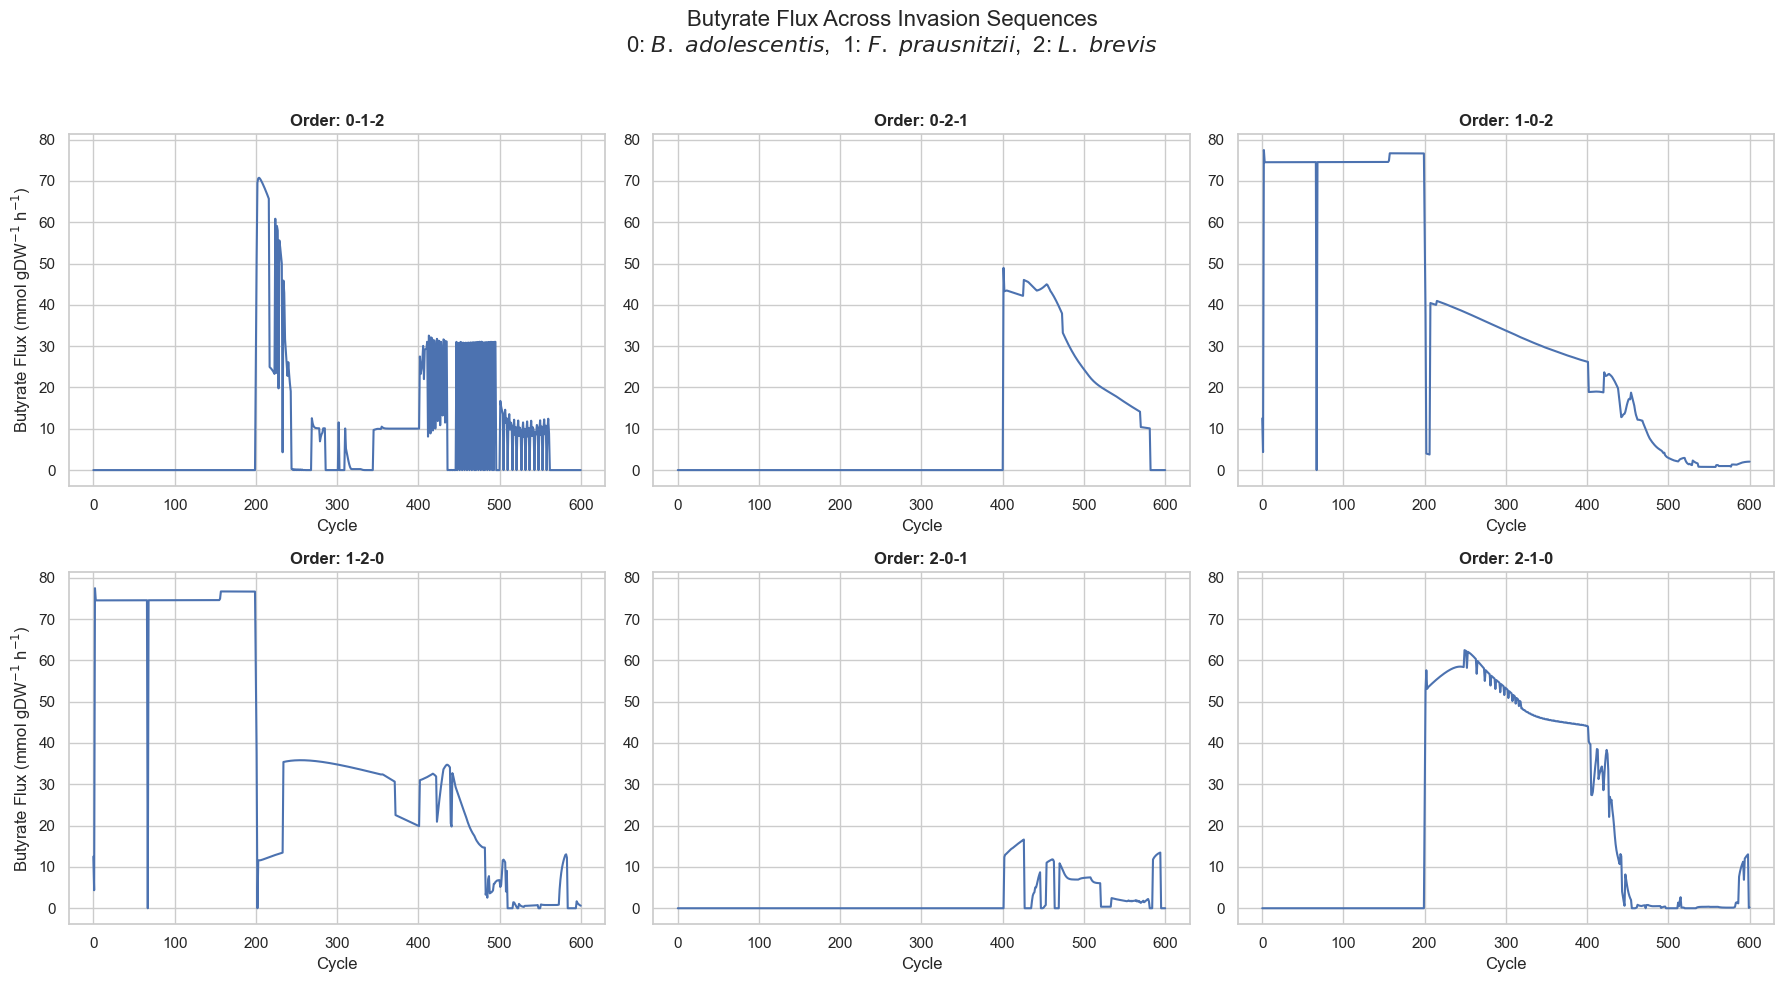

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

# === CONFIG ===
folder_path = '/Volumes/Mac Local/IITM/PhD/Coursework Sem 2/CSB/Project'  # 🔁 Update if needed
pattern = os.path.join(folder_path, 'butyrate_flux_sequence_*.csv')

# === Load all matching CSVs ===
all_files = glob.glob(pattern)

# === Prepare figure ===
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
axes = axes.flatten()

# === Loop through each file and plot ===
for idx, file in enumerate(sorted(all_files)):
    df = pd.read_csv(file)

    # Extract order name from filename for title
    order_name = os.path.basename(file).replace('butyrate_flux_sequence_', '').replace('.csv', '')

    # Get the max cycle number to include in the title (optional)
    max_cycle = df['cycle'].max()

    # Plot using 'cycle' column directly
    sns.lineplot(data=df, x='cycle', y='butyrate_flux', ax=axes[idx], ci=None)
    axes[idx].set_title(f"Order: {order_name}", fontweight='bold')
    axes[idx].set_xlabel("Cycle")
    axes[idx].set_ylabel("Butyrate Flux (mmol gDW$^{-1}$ h$^{-1}$)")
    
    # Ensure y-axis markings are visible for all subplots
    axes[idx].tick_params(axis='y', labelleft=True)

# === Final tweaks ===
plt.suptitle(
    r"""Butyrate Flux Across Invasion Sequences
0: $\mathit{B.\ adolescentis}$,  1: $\mathit{F.\ prausnitzii}$,  2: $\mathit{L.\ brevis}$""", 
    fontsize=16
)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for suptitle

plt.show()


Processing biomass_sequence_0-1-2.csv...


/var/folders/26/stf2735d0wg2czwkm2dlxlvm0000gn/T/ipykernel_17736/2981308212.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=melted_df, x='continuous_cycle', y='biomass', hue='model', ax=ax, ci=None)


Processing biomass_sequence_2-0-1.csv...


/var/folders/26/stf2735d0wg2czwkm2dlxlvm0000gn/T/ipykernel_17736/2981308212.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=melted_df, x='continuous_cycle', y='biomass', hue='model', ax=ax, ci=None)


Processing biomass_sequence_0-2-1.csv...


/var/folders/26/stf2735d0wg2czwkm2dlxlvm0000gn/T/ipykernel_17736/2981308212.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=melted_df, x='continuous_cycle', y='biomass', hue='model', ax=ax, ci=None)


Processing biomass_sequence_2-1-0.csv...


/var/folders/26/stf2735d0wg2czwkm2dlxlvm0000gn/T/ipykernel_17736/2981308212.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=melted_df, x='continuous_cycle', y='biomass', hue='model', ax=ax, ci=None)


Processing biomass_sequence_1-2-0.csv...


/var/folders/26/stf2735d0wg2czwkm2dlxlvm0000gn/T/ipykernel_17736/2981308212.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=melted_df, x='continuous_cycle', y='biomass', hue='model', ax=ax, ci=None)


Processing biomass_sequence_1-0-2.csv...


/var/folders/26/stf2735d0wg2czwkm2dlxlvm0000gn/T/ipykernel_17736/2981308212.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=melted_df, x='continuous_cycle', y='biomass', hue='model', ax=ax, ci=None)


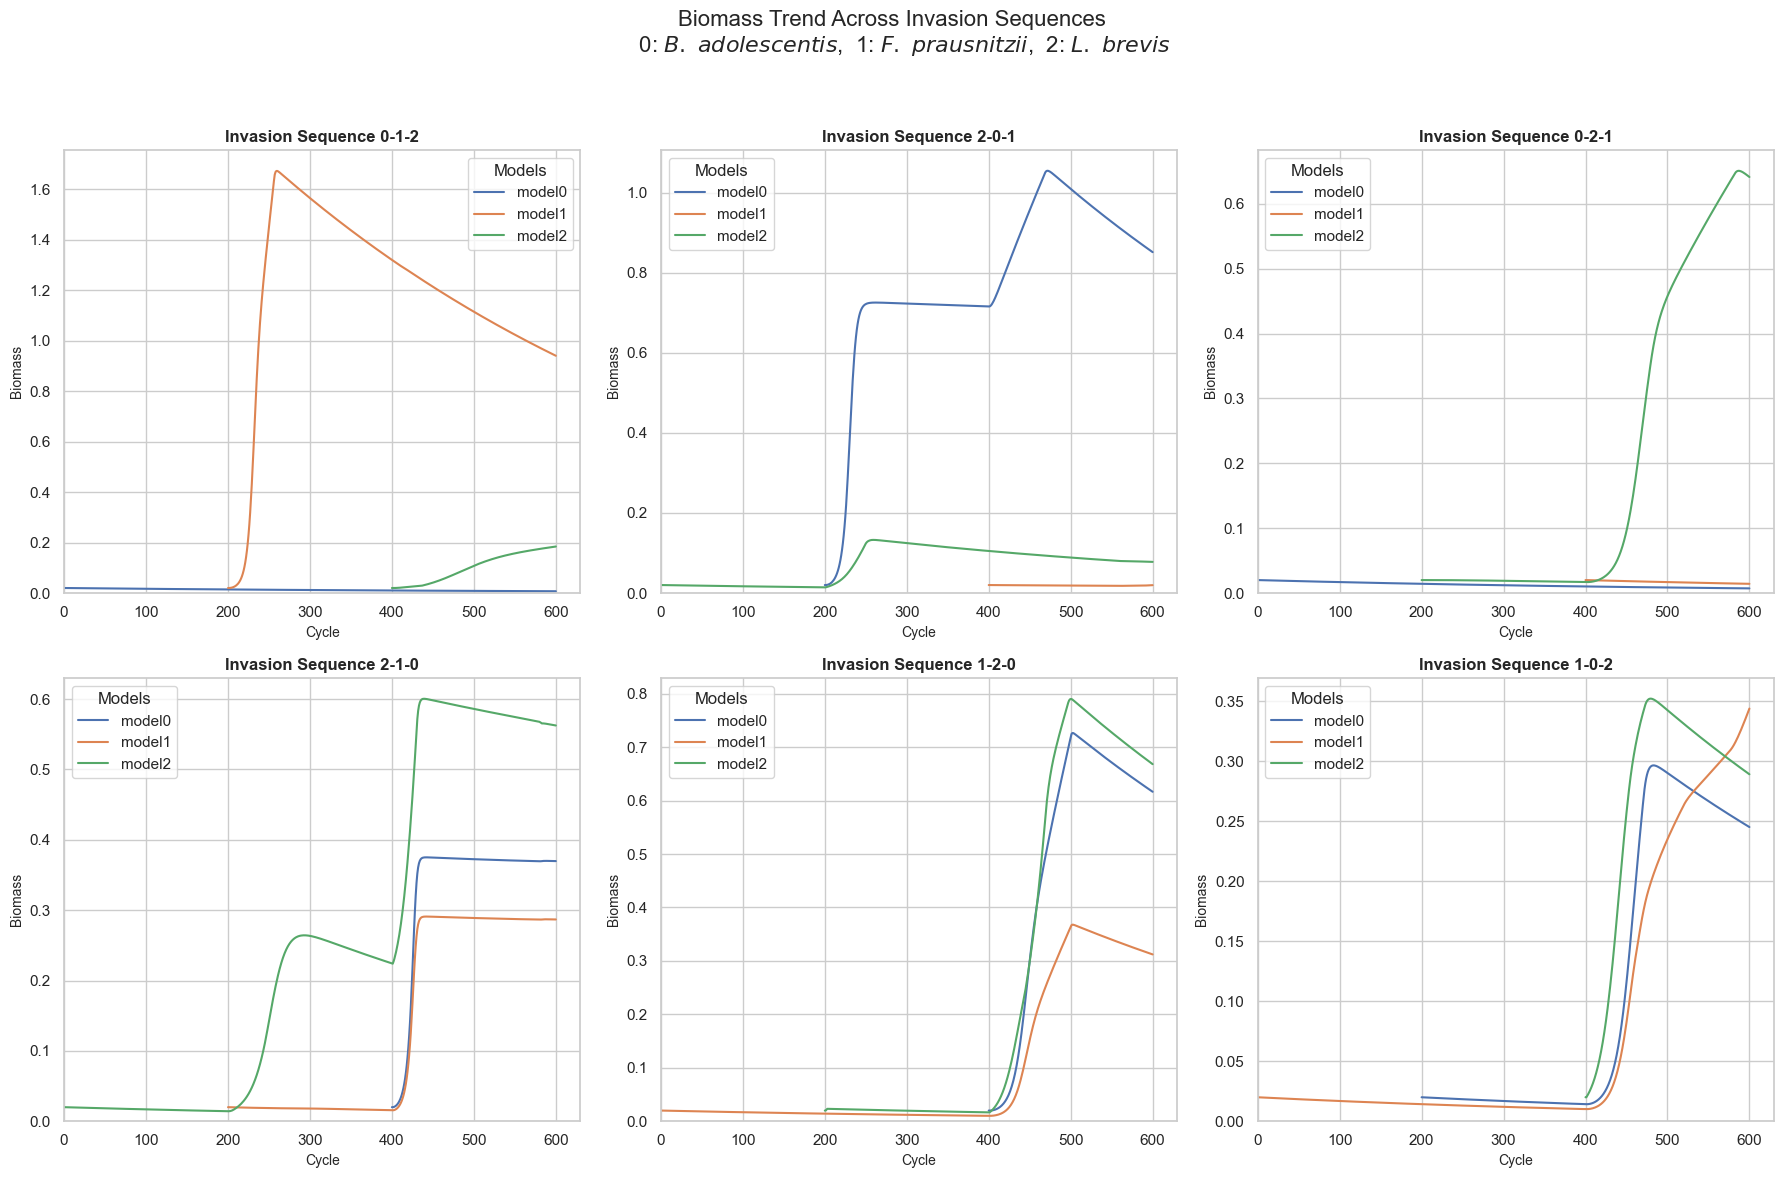

In [120]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Function to process and plot the biomass data from a CSV file
def plot_biomass_from_csv(file_path, ax):
    # Load the CSV file into a DataFrame
    final_df = pd.read_csv(file_path)
    
    # Create a new column 'continuous_cycle' that maps the old cycle to continuous cycle numbers (1-600)
    final_df['continuous_cycle'] = final_df['cycle'] + (final_df['invseq'] - 1) * 200
    
    # Drop rows where all biomass values are NaN (but keep rows with at least one valid biomass value)
    final_df_cleaned = final_df.dropna(subset=['model0', 'model1', 'model2'], how='all')
    
    # Melt the DataFrame to long format for seaborn
    melted_df = pd.melt(final_df_cleaned, id_vars=['continuous_cycle'], 
                        value_vars=['model0', 'model1', 'model2'], 
                        var_name='model', value_name='biomass')
    
    # Plotting biomass vs continuous cycle using sns.lineplot
    sns.lineplot(data=melted_df, x='continuous_cycle', y='biomass', hue='model', ax=ax, ci=None)
    
    # Add title and labels for each subplot
    basename = os.path.basename(file_path)
    match = re.search(r"biomass_sequence[_\-]?(.+?)\.csv", basename)

    if match:
        seq_name = match.group(1)
    else:
        seq_name = basename.split('.')[0]  # fallback

    # Set the title for each subplot
    ax.set_title(f"Invasion Sequence {seq_name}", fontsize=12, fontweight='bold')
    ax.set_xlabel("Cycle", fontsize=10)
    ax.set_ylabel("Biomass", fontsize=10)
    ax.legend(title="Models", loc='best')

    # Set x and y axes to start from 0
    ax.set_xlim(left=0)  # Start x-axis at 0
    ax.set_ylim(bottom=0)  # Start y-axis at 0

# Function to process all CSV files in a given folder and plot as subplots
def process_folder(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)
    
    # Filter files that start with 'biomass_sequence_'
    csv_files = [file for file in files if file.startswith('biomass_sequence_') and file.endswith('.csv')]
    
    # Create subplots (assuming you want a 2x3 grid for 6 plots)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2 rows, 3 columns of subplots
    axes = axes.flatten()  # Flatten the 2x3 grid into a 1D array of axes
    
    # Loop through each CSV file and plot the biomass data in subplots
    for i, csv_file in enumerate(csv_files):
        file_path = os.path.join(folder_path, csv_file)
        print(f"Processing {csv_file}...")
        
        # Plot biomass data on the corresponding subplot axis
        plot_biomass_from_csv(file_path, axes[i])
    
    # Add a main title for the entire figure
    plt.suptitle(
    r"""Biomass Trend Across Invasion Sequences
    0: $\mathit{B.\ adolescentis}$,  1: $\mathit{F.\ prausnitzii}$,  2: $\mathit{L.\ brevis}$""", 
    fontsize=16
    )
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
    
    # Show the combined plot with all subplots
    plt.show()

# Example usage: Replace this with your folder path
folder_path = '/Volumes/Mac Local/IITM/PhD/Coursework Sem 2/CSB/Project'  # Change this to your folder path

# Process all files in the folder and plot as subplots
process_folder(folder_path)
